### Importações

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.ensemble import IsolationForest

### Criando o DF

In [18]:
%reload_ext autoreload
sys.path.append(os.path.abspath('..'))
from functions.clean_df import load_and_combine_csvs,clean_dataframe
from functions.state_imput import apply_state_estimation
from functions.feature_engineering import feature_engineering
from functions.preprocessing import get_preprocessor
from functions.models import run_if_normal, run_if_classified

In [19]:
csv_path = '../raw_data'

df = load_and_combine_csvs(csv_path)
df_clean = clean_dataframe(df)
df_clean = apply_state_estimation(df_clean)
df_clean = feature_engineering(df_clean)

### Feature Engineering para Isolation Forest

In [20]:
def add_frequency_features(df, cols_categoria):
    """
    Adiciona colunas de frequência normalizada para cada coluna categórica.
    Ex: 'NOME ÓRGÃO' -> 'FREQ_NOME ÓRGÃO'
    """
    df = df.copy()

    for col in cols_categoria:
        freq_map = df[col].value_counts(normalize=True)
        df[f'FREQ_{col}'] = df[col].map(freq_map)

    return df

In [21]:
def add_monthly_ratio_features(df):
    """
    Cria duas features:
    - MEDIA_VALOR_ORGAO_MES_LOG: média do órgão no ano/mês (log)
    - RATIO_MES: valor da transação dividido pela média original (não log)
    """
    df = df.copy()

    # média original
    df['MEDIA_VALOR_ORGAO_MES'] = (
        df.groupby(['NOME ÓRGÃO', 'ANO EXTRATO', 'MÊS EXTRATO'])['VALOR TRANSAÇÃO']
          .transform('mean')
          .round(2)
    )

    # média em log (evitando log(0))
    df['MEDIA_VALOR_ORGAO_MES'] = (df['MEDIA_VALOR_ORGAO_MES'] + 1).apply(np.log)

    # ratio usando a média original
    df['RATIO_MES'] = df['VALOR TRANSAÇÃO'] / df['MEDIA_VALOR_ORGAO_MES']

    return df

In [22]:
cols_categorica = ['NOME ÓRGÃO', 'ESTADO_ESTIMADO', 'NOME FAVORECIDO']
df_clean = add_frequency_features(df_clean, cols_categorica)

In [23]:
df_clean = add_monthly_ratio_features(df_clean)

### Aplicando Processamento de Dados

In [10]:
df_clean_sigiloso0 = df_clean[df_clean['SIGILOSO'] == 0].copy()
df_clean_sigiloso1 = df_clean[df_clean['SIGILOSO'] == 1].copy()

In [11]:
preprocessor = get_preprocessor()
preprocessor.fit(df_clean)

X_scaled_sigiloso0 = preprocessor.transform(df_clean_sigiloso0)
X_scaled_sigiloso1 = preprocessor.transform(df_clean_sigiloso1)

### Treinando o Modelo

In [12]:
iso0 = IsolationForest(contamination=0.01, random_state=42)

iso0.fit(X_scaled_sigiloso0)
df_clean_sigiloso0['IF_LABEL'] = iso0.predict(X_scaled_sigiloso0)
df_clean_sigiloso0['IF_SCORE'] = iso0.score_samples(X_scaled_sigiloso0)

In [13]:
iso1 = IsolationForest(contamination=0.01, random_state=42)

iso1.fit(X_scaled_sigiloso1)
df_clean_sigiloso1['IF_LABEL'] = iso1.predict(X_scaled_sigiloso1)
df_clean_sigiloso1['IF_SCORE'] = iso1.score_samples(X_scaled_sigiloso1)

In [14]:
anomalias_sigiloso0 = df_clean_sigiloso0[df_clean_sigiloso0['IF_LABEL'] == -1]
len(anomalias_sigiloso0)

2890

In [15]:
anomalias_sigiloso1 = df_clean_sigiloso1[df_clean_sigiloso1['IF_LABEL'] == -1]
len(anomalias_sigiloso1)

179

In [16]:
anomalias_sigiloso1['DATA TRANSAÇÃO'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]

In [17]:
anomalias_sigiloso1.head()

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,ID_PORTADOR,FIM_SEMANA,LOG_VALOR,FREQ_NOME ÓRGÃO,FREQ_ESTADO_ESTIMADO,FREQ_NOME FAVORECIDO,MEDIA_VALOR_ORGAO_MES,RATIO_MES,IF_LABEL,IF_SCORE
9517,20000,Presidência da República,20101,Presidência da República,110538,AGENCIA BRASILEIRA DE INTELIGENCIA,2023,5,NaN,Sigiloso,...,NaN,0,9.903538,0.040406,0.224069,0.058215,8.735843,2289.418313,-1,-0.643812
9771,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2023,5,NaN,Sigiloso,...,NaN,0,10.722475,0.040406,0.037757,0.058215,8.735843,5192.749869,-1,-0.668567
9776,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2023,5,NaN,Sigiloso,...,NaN,0,10.847433,0.040406,0.037757,0.058215,8.735843,5883.920679,-1,-0.674473
9780,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2023,5,NaN,Sigiloso,...,NaN,0,11.417836,0.040406,0.037757,0.058215,8.735843,10408.634310,-1,-0.692434
9787,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2023,5,NaN,Sigiloso,...,NaN,0,10.427845,0.040406,0.037757,0.058215,8.735843,3867.568157,-1,-0.646170


### Visualização

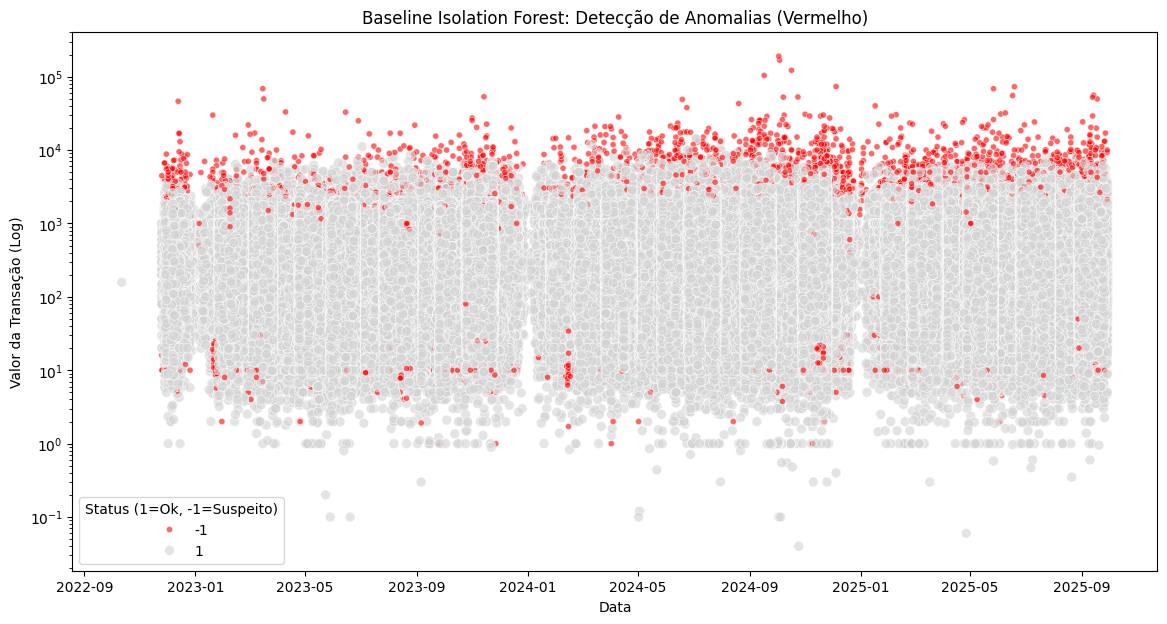

In [18]:
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_clean_sigiloso0,
    x='DATA TRANSAÇÃO',
    y='VALOR TRANSAÇÃO',
    hue='IF_LABEL',
    palette={1: 'lightgrey', -1: 'red'},
    alpha=0.6,
    size='IF_LABEL',
    sizes=(20, 50)
)
plt.yscale('log')
plt.title('Baseline Isolation Forest: Detecção de Anomalias (Vermelho)')
plt.ylabel('Valor da Transação (Log)')
plt.xlabel('Data')
plt.legend(title='Status (1=Ok, -1=Suspeito)')
plt.show()

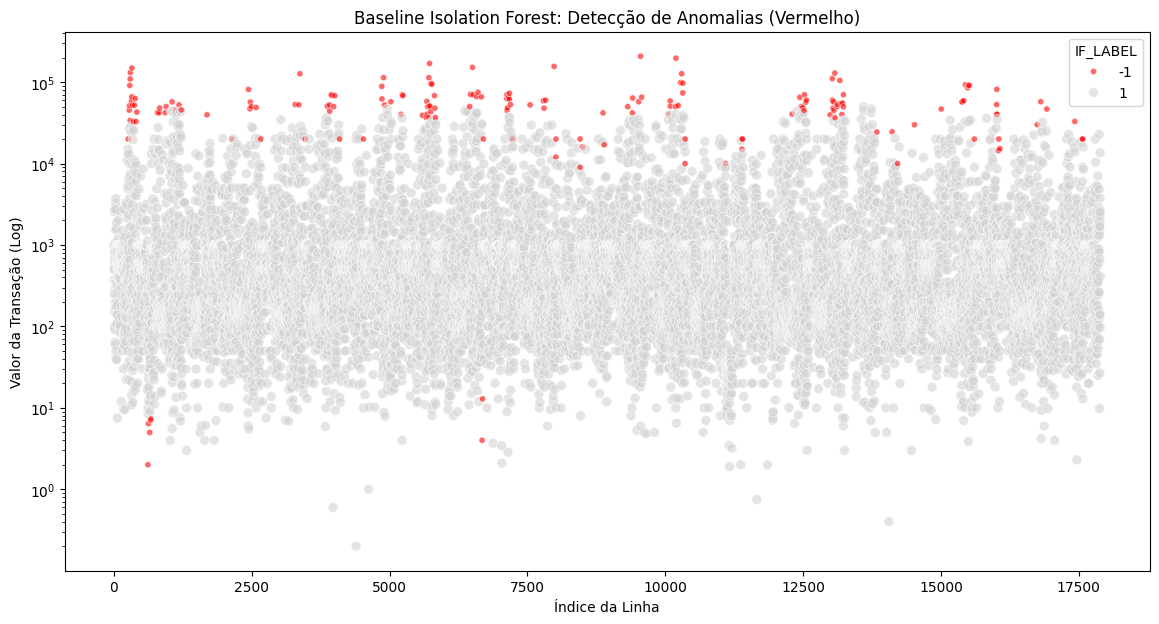

In [19]:
df_plot = df_clean_sigiloso1.reset_index()

plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_plot,
    x=df_plot.index,
    y='VALOR TRANSAÇÃO',
    hue='IF_LABEL',
    palette={1: 'lightgrey', -1: 'red'},
    alpha=0.6,
    size='IF_LABEL',
    sizes=(20, 50)
)
plt.yscale('log')
plt.title('Baseline Isolation Forest: Detecção de Anomalias (Vermelho)')
plt.ylabel('Valor da Transação (Log)')
plt.xlabel('Índice da Linha')
plt.show()

In [20]:
len(df_clean_sigiloso0), len(df_clean_sigiloso1)

(289417, 17890)

### Top suspeitos

In [21]:
cols_view = ['NOME ÓRGÃO', 'NOME FAVORECIDO', 'VALOR TRANSAÇÃO', 'DATA TRANSAÇÃO', 'ESTADO_ESTIMADO', 'IF_SCORE']
top_anomalias_sigiloso0 = df_clean_sigiloso0[df_clean_sigiloso0['IF_LABEL'] == -1].sort_values('IF_SCORE', ascending=True).head(100)
top_anomalias_sigiloso0.head()[cols_view]

,NOME ÓRGÃO,NOME FAVORECIDO,VALOR TRANSAÇÃO,DATA TRANSAÇÃO,ESTADO_ESTIMADO,IF_SCORE
35684,"Instituto Federal de Educação, Ciência e Tecno...",SEM INFORMACAO,40000.00,2025-01-17,MT,-0.704595
134674,Instituto Chico Mendes de Conservação da Biodi...,SEM INFORMACAO,19675.00,2024-12-01,SE,-0.704439
238793,Comando da Aeronáutica,SEM INFORMACAO,15349.60,2025-02-15,UNIÃO,-0.702215
134676,Instituto Chico Mendes de Conservação da Biodi...,SEM INFORMACAO,11600.00,2024-12-11,SE,-0.702060
213706,Comando da Aeronáutica,SEM INFORMACAO,26005.53,2025-05-27,UNIÃO,-0.701176


In [22]:
cols_view = ['NOME ÓRGÃO', 'NOME FAVORECIDO', 'VALOR TRANSAÇÃO', 'DATA TRANSAÇÃO', 'ESTADO_ESTIMADO', 'IF_SCORE']
top_anomalias_sigiloso1 = df_clean_sigiloso1[df_clean_sigiloso1['IF_LABEL'] == -1].sort_values('IF_SCORE', ascending=True).head(100)
top_anomalias_sigiloso1.head()[cols_view]

,NOME ÓRGÃO,NOME FAVORECIDO,VALOR TRANSAÇÃO,DATA TRANSAÇÃO,ESTADO_ESTIMADO,IF_SCORE
9792,Presidência da República,Sigiloso,130944.55,NaT,PR,-0.699967
9847,Presidência da República,Sigiloso,149071.09,NaT,PR,-0.699967
9790,Presidência da República,Sigiloso,109373.25,NaT,PR,-0.699493
51573,Presidência da República,Sigiloso,81228.18,NaT,PR,-0.694668
9780,Presidência da República,Sigiloso,90928.20,NaT,PR,-0.692434


### Teste da função

In [24]:
resultado_s0 = run_if_normal(df_clean)

resultado_s0.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,ID_PORTADOR,FIM_SEMANA,LOG_VALOR,FREQ_NOME ÓRGÃO,FREQ_ESTADO_ESTIMADO,FREQ_NOME FAVORECIDO,MEDIA_VALOR_ORGAO_MES,RATIO_MES,IF_LABEL,IF_SCORE
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,...,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0,6.523562,0.006521,0.216305,0.098263,5.612507,121.157968,1,0.049168
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,...,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0,6.478510,0.006521,0.216305,0.098263,5.612507,115.812763,1,0.044603


In [25]:
resultado_s1 = run_if_classified(df_clean)

resultado_s1.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,ID_PORTADOR,FIM_SEMANA,LOG_VALOR,FREQ_NOME ÓRGÃO,FREQ_ESTADO_ESTIMADO,FREQ_NOME FAVORECIDO,MEDIA_VALOR_ORGAO_MES,RATIO_MES,IF_LABEL,IF_SCORE
5753,25000,Ministério da Fazenda,25915,Fundo Constitucional do Distrito Federal,170395,FCDF±SSP ± POLICIA CIVIL DO DF,2025,6,NaN,Sigiloso,...,NaN,0,6.908755,0.006664,0.224069,0.058215,7.281007,137.343638,1,0.062702
5754,25000,Ministério da Fazenda,25915,Fundo Constitucional do Distrito Federal,170395,FCDF±SSP ± POLICIA CIVIL DO DF,2025,6,NaN,Sigiloso,...,NaN,0,6.216606,0.006664,0.224069,0.058215,7.281007,68.671819,1,0.075493
